In [2]:
# Authors: David Moiraf, david.moiraf@cea.fr
# Authors: Magne Lauritzen, mag.lauritzen@gmail.com

# -- use this line at the beginning of your notebook to turn on interactive plots
# %matplotlib notebook
%matplotlib inline

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar

# Import DataClass for condensed pedestal data
%run ./functions.ipynb

In [3]:
def combine_pedestalparams(pp_list):
    def extract_subset(name):
        return np.concatenate(tuple([getattr(pp, name).data for pp in pp_list]))
        
    toplist = ['pe', 'ne', 'Te']
    subset_list = ['height', 'height_err', 'grad', 'grad_err', 'width', 'width_err', 'time', 'ELM_phase', 'ST_phase', 'ST_time']
    
    d = {}
    for topname in toplist:
        subd = {}
        for subname in subset_list:
            name = f"{topname}_{subname}"
            concat_arr = extract_subset(name)
            subd[subname] = concat_arr
        subd[topname] = subd
    
    subd['shot_nr'] = np.concatenate(tuple([np.full(pp.shot_number, len(pp.ne_height.data)) for pp in pp_list]))
    return subd
    

In [4]:
def get_ELM_ST_phase_and_duration(shot_nr: int):
    shot = cdbxr.Shot(shot_nr)
    t_ELM_start = shot['t_ELM_start']
    ELM_duration = np.diff(t_ELM_start)
    
    ELM_ST_phase, ELM_ST_time, ST_amplitudes = ST_time_and_phase(shot_nr, t_ELM_start[1:])
    return ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time 



In [5]:
# Define a dataclass to hold the pedestal fit results
@dataclass
class PedestalParams:
    shot_number: int
    
    ne_height: np.ndarray
    ne_height_err: np.ndarray
    ne_grad: np.ndarray
    ne_grad_err: np.ndarray
    ne_width: np.ndarray
    ne_width_err: np.ndarray
    ne_time: np.ndarray
    ne_ELM_phase: np.ndarray
    ne_ELM_time: np.ndarray
    ne_ST_phase: np.ndarray
    ne_ST_time: np.ndarray
        
    Te_height: np.ndarray
    Te_height_err: np.ndarray
    Te_grad: np.ndarray
    Te_grad_err: np.ndarray
    Te_width: np.ndarray
    Te_width_err: np.ndarray
    Te_time: np.ndarray
    Te_ELM_phase: np.ndarray
    Te_ELM_time: np.ndarray
    Te_ST_phase: np.ndarray
    Te_ST_time: np.ndarray
        
    pe_height: np.ndarray
    pe_height_err: np.ndarray
    pe_grad: np.ndarray
    pe_grad_err: np.ndarray
    pe_width: np.ndarray
    pe_width_err: np.ndarray
    pe_time: np.ndarray
    pe_ELM_phase: np.ndarray
    pe_ELM_time: np.ndarray
    pe_ST_phase: np.ndarray
    pe_ST_time: np.ndarray

In [6]:
pedestal_data_folder = Path('./pedestal_data')
pedestal_data_list = []

for item in pedestal_data_folder.iterdir():
    if item.is_file and item.suffix == ".bin":
        with open(item, 'rb') as fp:
            pedestal_data_list.append(pickle.load(fp))

In [7]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, c='C0', cmap='jet'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)

    # now determine nice limits by hand:
    x_max = np.nanmax(x)
    y_max = np.nanmax(y)
    x_min = np.nanmin(x)
    y_min = np.nanmin(y)

    x_bins = np.linspace(x_min, x_max, 60)
    y_bins = np.linspace(y_min, y_max, 60)
    
    if isinstance(c, np.ndarray):
        ax_histx.hist(x, bins=x_bins, color='C2')
        ax_histy.hist(y, bins=y_bins, orientation='horizontal', color='C2')
    else:
        ax_histx.hist(x, bins=x_bins, color=c)
        ax_histy.hist(y, bins=y_bins, orientation='horizontal', color=c)

/tmp/ipykernel_3589749/723218695.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)


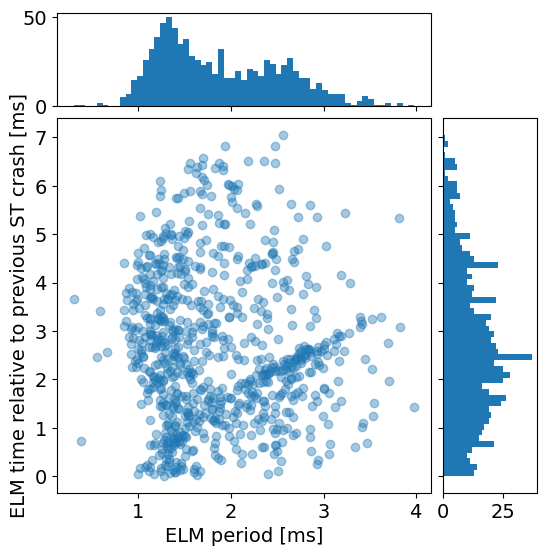

In [8]:
ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)
    
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ELM period [ms]')
plt.ylabel('ELM time relative to previous ST crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ELM_duration_tot, ELM_ST_time_tot, ax, ax_histx, ax_histy)

/tmp/ipykernel_3589749/723218695.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)


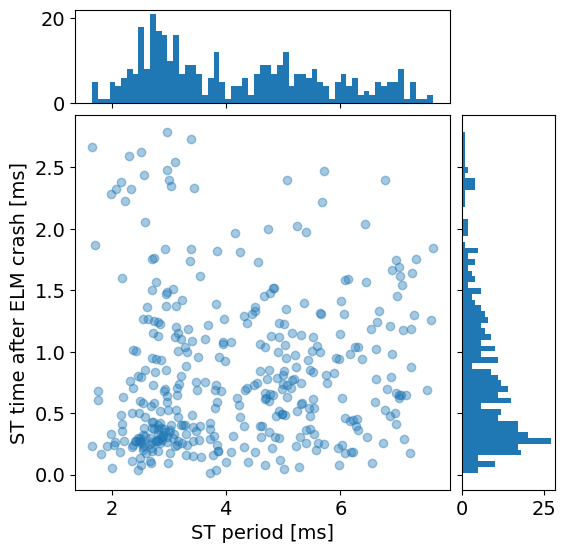

In [9]:
ST_delay_after_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_ELM_phases, ST_delay_after_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times)
    ST_periods = np.diff(ST_times)
    ST_delay_after_ELM = ST_delay_after_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_delay_after_ELM_tot = np.concatenate((ST_delay_after_ELM_tot, ST_delay_after_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time after ELM crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_delay_after_ELM_tot, ax, ax_histx, ax_histy)

/tmp/ipykernel_3589749/723218695.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)


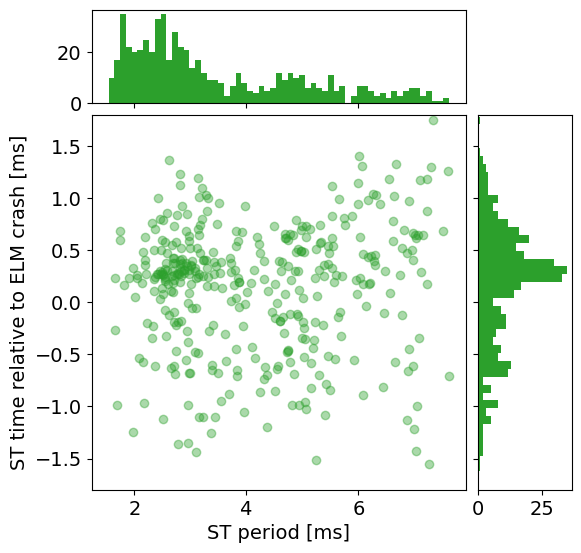

In [10]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c='C2')

/tmp/ipykernel_3589749/723218695.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)


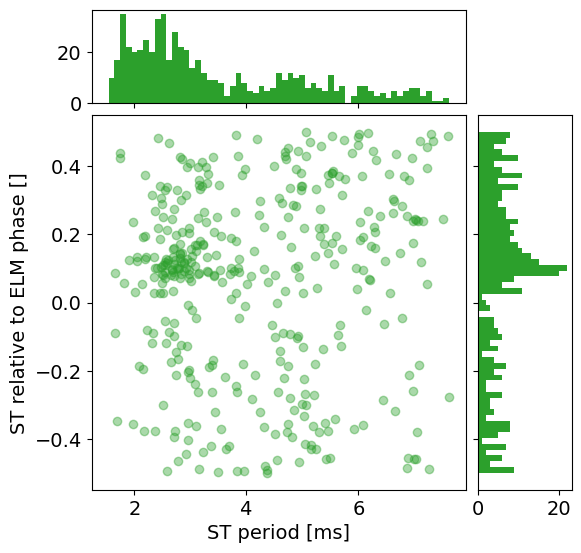

In [12]:
ST_relative_to_nearest_ELM_phase_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_relative_to_nearest_ELM_phase = ST_relative_to_nearest_ELM_phase[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_relative_to_nearest_ELM_phase_tot = np.concatenate((ST_relative_to_nearest_ELM_phase_tot, ST_relative_to_nearest_ELM_phase[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST relative to ELM phase []')
#plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_relative_to_nearest_ELM_phase_tot, ax, ax_histx, ax_histy, c='C2')

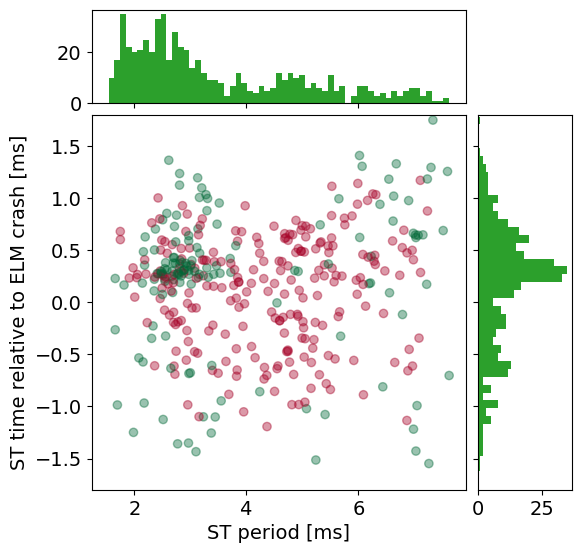

In [13]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask2 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c=elm_duration_tot, cmap='RdYlGn')

In [ ]:
get_ELM_ST_phase_and_duration

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c='C2')

/tmp/ipykernel_3589749/723218695.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, c=c, alpha=0.4, cmap=cmap)


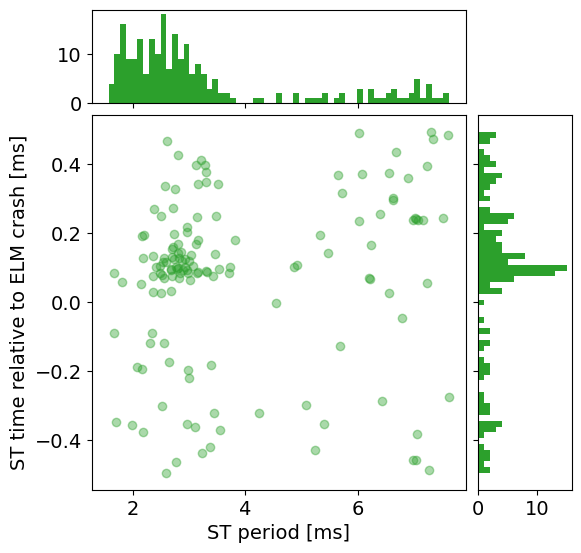

In [14]:
ST_phase_in_ELM_period_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    #ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_phase_in_ELM_period = ST_phase_in_ELM_period[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_phase_in_ELM_period_tot = np.concatenate((ST_phase_in_ELM_period_tot, ST_phase_in_ELM_period[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
#plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_phase_in_ELM_period_tot, ax, ax_histx, ax_histy, c='C2')